Loading trained model from 'svm_cat_dog_classifier_20k.joblib'...


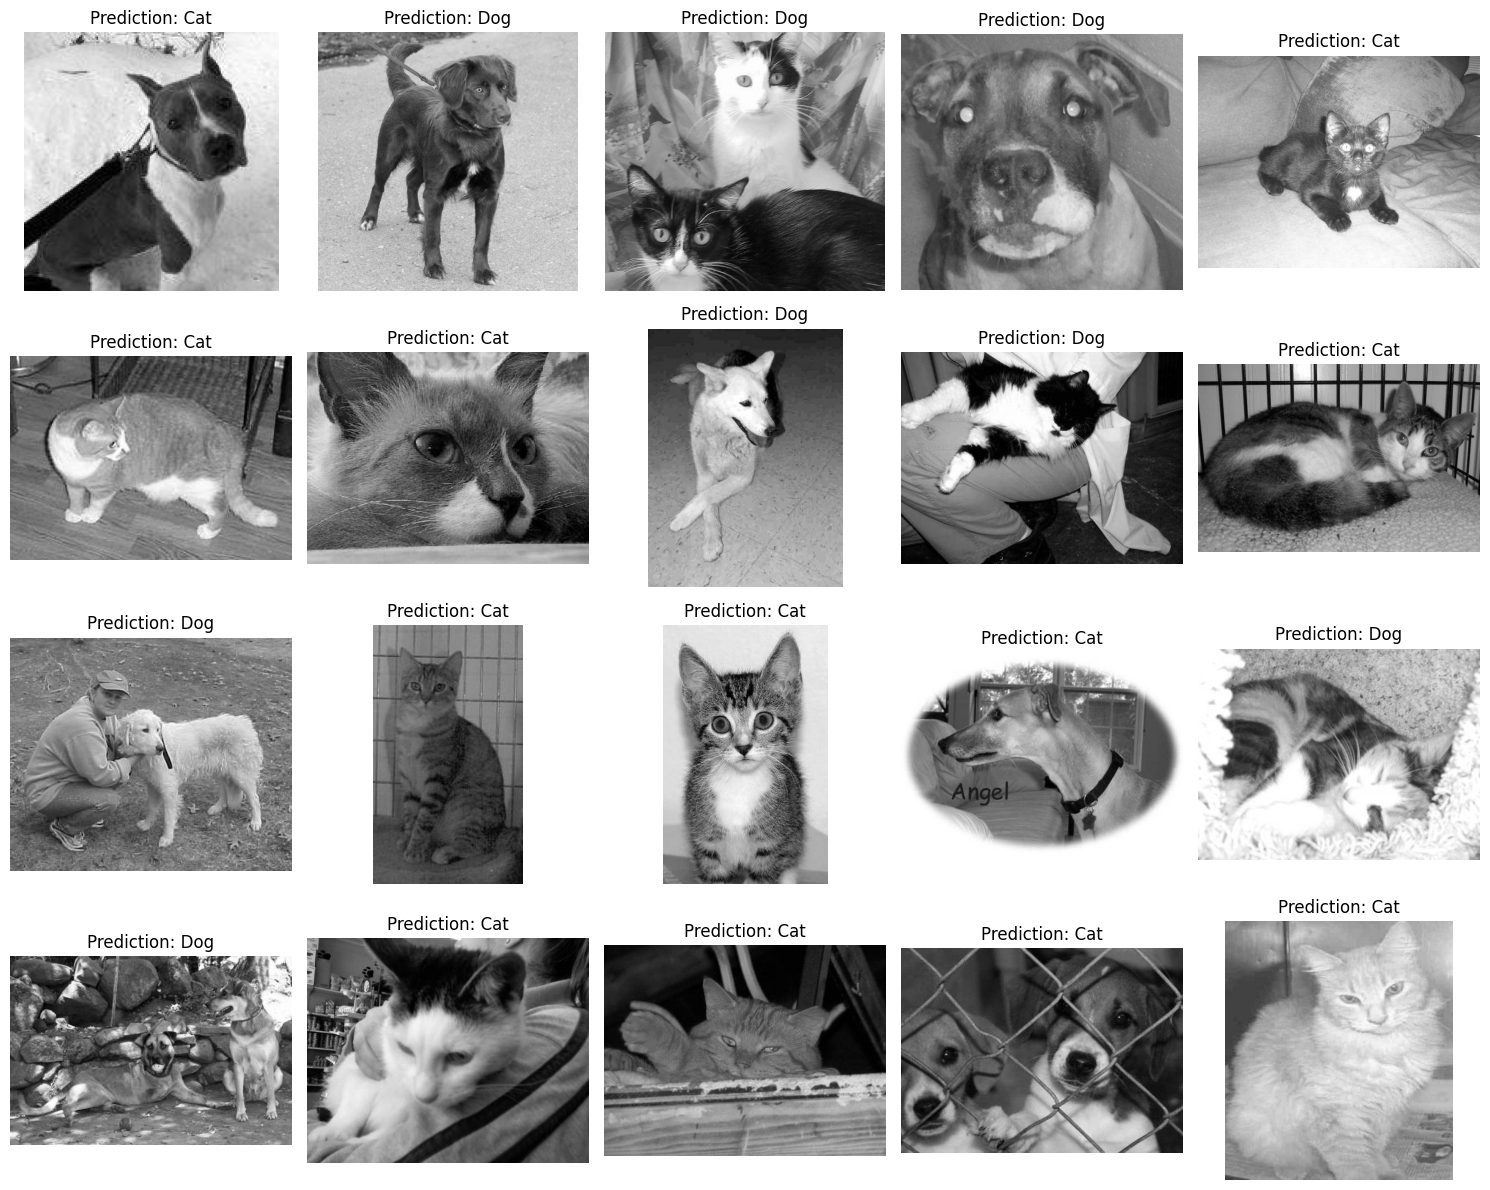

In [9]:
import cv2
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import random
from glob import glob

MODEL_FILENAME = 'svm_cat_dog_classifier_20k.joblib'
TEST_DIR = 'dataset/test/'  # Directory containing test images
IMG_SIZE = 64
NUM_TEST_IMAGES = 20  # Number of random images to test

# A mapping to translate the model's output (0 or 1) to a readable name
label_map = {0: 'Cat', 1: 'Dog'}

print(f"Loading trained model from '{MODEL_FILENAME}'...")
try:
    # Load the model
    loaded_model = joblib.load(MODEL_FILENAME)
except FileNotFoundError:
    print(f"FATAL ERROR: Model file not found at '{MODEL_FILENAME}'")
    print("Please make sure you have trained the model and the file is in the correct folder.")
    exit()

# Get all image paths from the test directory
all_test_images = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    all_test_images.extend(glob(os.path.join(TEST_DIR, ext)))

if len(all_test_images) == 0:
    print(f"ERROR: No images found in '{TEST_DIR}'")
    exit()

# Select random images for testing
if len(all_test_images) > NUM_TEST_IMAGES:
    test_images = random.sample(all_test_images, NUM_TEST_IMAGES)
else:
    test_images = all_test_images
    print(f"Warning: Only {len(test_images)} images found, testing all of them.")

# Filter out images that can't be read before creating the figure
valid_images = []
for image_path in test_images:
    image = cv2.imread(image_path)
    if image is not None:
        valid_images.append(image_path)
    else:
        print(f"Warning: Could not read image at '{image_path}', skipping.")

if not valid_images:
    print("ERROR: No valid images found to test.")
    exit()

# Determine grid size based on number of valid images
n_images = len(valid_images)
n_cols = min(5, n_images)
n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

# Create a figure to display the predictions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
if n_rows * n_cols > 1:  # If multiple subplots
    axes = axes.flatten()
else:  # If only one subplot
    axes = [axes]

# Process each test image
for i, image_path in enumerate(valid_images):
    if i >= len(axes):  # Safety check
        break
        
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Keep a copy of the original image for display
    original_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Preprocess the image
    resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    flattened_image = resized_image.flatten()
    normalized_image = flattened_image / 255.0
    final_image = normalized_image.reshape(1, -1).astype(np.float32)
    
    # Make prediction
    prediction = loaded_model.predict(final_image)
    predicted_label_index = prediction[0]
    predicted_label_name = label_map[predicted_label_index]
    
    # Display prediction
    axes[i].imshow(original_image)
    axes[i].set_title(f'Prediction: {predicted_label_name}')
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    axes[j].set_visible(False)

# Display predictions
plt.tight_layout()
plt.show()